In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from scipy.stats import chi2
import numpy as np

# Plot data using Plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# For forest plot
import forestplot as fp


In [3]:
!gunzip -c Downloaded_Data/GenovoLOEUF.txt.gz | head -n 5

enstID	enstVersion	observed_genovo_in_frame_indel	observed_genovo_missense	observed_genovo_synonymous	observed_genovo_frameshift_indel	observed_genovo_LoF	observed_genovo_nonsense	observed_genovo_splice_site	observed_genovo_stop_loss	expected_genovo_in_frame_indel	expected_genovo_missense	expected_genovo_synonymous	expected_genovo_frameshift_indel	expected_genovo_LoF	expected_genovo_nonsense	expected_genovo_splice_site	expected_genovo_stop_loss	expected_lower_genovo_in_frame_indel	expected_lower_genovo_missense	expected_lower_genovo_synonymous	expected_lower_genovo_frameshift_indel	expected_lower_genovo_LoF	expected_lower_genovo_nonsense	expected_lower_genovo_splice_site	expected_lower_genovo_stop_loss	mean_AN	genovo_synonymous_OE_ratio_uncorrected	lowess_factor	expected_genovo_missense_corrected	expected_genovo_synonymous_corrected	expected_genovo_frameshift_indel_corrected	expected_genovo_LoF_corrected	expected_genovo_nonsense_corrected	expected_genovo_splice_site_corrected	expected_

In [2]:
def extract_elof_genes(row, pli: float, oe_lof_upper: float, phaplo: float):
    if (row['pLI'] > pli
            and row['oe_lof_upper'] < oe_lof_upper
            and row['pHaplo'] >= phaplo):
        return True
    else:
        return False 

def extract_g2pLoF_genes(x):
    if 'absent gene product' in x:
        return 'PASS'
    else:
        return '.'

def extract_definitive(x):
    if x == 'definitive':
        return 'PASS'
    else:
        return '.'

def extract_strong(x):
    if (x == 'definitive' or x == 'strong'):
        return 'PASS'
    else:
        return '.'

def extract_moderate(x):
    if (x == 'definitive' or x == 'strong' or x == 'moderate'):
        return 'PASS'
    else:
        return '.'
        
def create_gene_list(
        ajhg: pd.DataFrame, alldf: pd.DataFrame,
        higene: pd.DataFrame, gnomad: pd.DataFrame,
        set_name: str, pli: float, oe_lof_upper: float, 
        phaplo: float, hi: int, dcpr_definitive: str, 
        ) -> set:
    
    # AJHG genes 
    ajhg_genes = set(ajhg['Approved_Symbol'])

    # HI genes
    hi_genes = set(higene.loc[higene['HIscore'] >= hi, 'Approved_Symbol'])
    
    # Extract G2P genes
    alldf_filterd = alldf[alldf[f"{dcpr_definitive}FILTER"] == 'PASS']
    dcpr_genes = set(alldf_filterd['Approved_Symbol'])
    
    # Filteration of pLI, oe_lof_upper and pHaplo score
    gnomad['is_eLoF'] = gnomad.apply(
        extract_elof_genes, args=(pli, oe_lof_upper, phaplo), axis=1)
    gnomad_genes = set(gnomad.loc[gnomad['is_eLoF'] == True, 'Approved_Symbol'])

    # Union of all eLoF genes
    gene_set: set = (gnomad_genes).union(dcpr_genes).union(hi_genes).union(ajhg_genes)
    
    # Count
    print(f"{set_name} AJHG:DCPR:HI:pHaplo:Total - {len(ajhg_genes)} {len(dcpr_genes)} {len(hi_genes)} {len(gnomad_genes)} {len(gene_set)}")
    
    return set_name, gene_set


def create_individual_gene_list(
        ajhg: pd.DataFrame, alldf: pd.DataFrame,
        higene: pd.DataFrame, gnomad: pd.DataFrame,
        set_name: str, pli: float, oe_lof_upper: float, 
        phaplo: float, hi: int, dcpr_definitive: str
        ) -> tuple:
    
    # AJHG genes 
    ajhg_genes = set(ajhg['Approved_Symbol'])

    # HI genes
    higene = higene.astype({'HIscore': int})
    higene = higene.loc[higene['HIscore'] >= hi, 'Approved_Symbol']
    hi_genes = set(higene)
    
    # Extract G2P genes
    alldf_filterd = alldf[alldf[f"{dcpr_definitive}FILTER"] == 'PASS']
    dcpr_genes = set(alldf_filterd['Approved_Symbol'])
    
    # Filteration of pLI, oe_lof_upper and pHaplo score
    gnomad['is_eLoF'] = gnomad.apply(
        extract_elof_genes, args=(pli, oe_lof_upper, phaplo), axis=1)
    gnomad_genes = set(gnomad.loc[gnomad['is_eLoF'] == True, 'Approved_Symbol'])

    return ajhg_genes, dcpr_genes, hi_genes, gnomad_genes


def calc_odds_ratio(
        group: str, label: str,
        a: int, b: int, c: int, d: int, z: float) -> tuple:
    
    odds_ratio = (a * d) / (b * c)
    log_odds = np.log(odds_ratio)
    se = np.sqrt(1/a + 1/b + 1/c + 1/d)
    logci: tuple = log_odds - z * se, log_odds + z * se

    # Example of a contingency table for the odds ratio calculation
    # |-----------|----------|----------|
    # |           | Positive | Negative |
    # |-----------|----------|----------|
    # | eLoF      | a        | b        |
    # | Not eLoF  | c        | d        |
    # |-----------|----------|----------|
    # z = 1.96 for 95% CI z: float
    # z = 2.58 for 99% CI
    # ci: tuple = np.exp(log_odds - z * se), np.exp(log_odds + z * se)

    # Chi2 test
    chi2, p = chi2_contingency([[a, b], [c, d]])[:2]

    # result_logor = '{:.2f}'.format(log_odds)
    # result_ci_lower = '{:.3f}'.format(logci[0])
    # result_ci_upper = '{:.3f}'.format(logci[1])

    return ['{:.3f}'.format(log_odds), '{:.3f}'.format(logci[0]), '{:.3f}'.format(logci[1]), p, group, label]

In [3]:
# Path to a directory includinf downloaded data
data_dir: str = 'Downloaded_Data'

### Lodading canonical transcripts
canonlist = '../01_CanonicalTranscripts/CanonicalTranscripts.exoncount.tsv'
canon = pd.read_table(canonlist, sep='\t', header=0)
canon_set = set(canon['ENST'])

# Curation data
ajhg_path = 'AJHG_ClinGenLoF_genes.txt.gz'
hi_path = 'ClinGen_haploinsufficiency_gene_GRCh37.bed'
gnomad_path = 'gnomad.v2.1.1.lof_metrics.by_gene.txt.gz'
phaplo_path = 'Collins_rCNV_2022.dosage_sensitivity_scores.tsv.gz'

# G2P data
dd = f'{data_dir}/G2P/DDG2P.csv.gz'
eye = './EyeG2P.csv.gz'
skin = './SkinG2P.csv.gz'
cancer = './CancerG2P.csv.gz'
cardiac = './CardiacG2P.csv.gz'
skeletal = './SkeletalG2P.csv.gz'

# Validation set
am_path = 'AlphaMissense_gene_hg19.tsv.gz'
am_path = 'AlphaMissense_gene_level_list.txt'
genovo_path = 'GenovoLOEUF.txt.gz'
gnocchi_path = 'EnhancerGnocchi.txt.gz'


#### Pre-processicng for HGNC ID annotation

In [4]:
# Define function for symbol conversion to Approved symbol from Alias or Previous symbol
fp_hgnc_all_results = "HGNC_BioMart/HGNC_BioMart_all_results.txt"
df_hgnc_biomart_data = pd.read_table(fp_hgnc_all_results, sep='\t', header=0)

approved_symbols = set(df_hgnc_biomart_data['Approved symbol'])
alias_symbols = set(df_hgnc_biomart_data['Alias symbol'])
prev_symbols = set(df_hgnc_biomart_data['Previous symbol'])

def convert_to_approved_symbol(x):
    if x in approved_symbols:
        return x
    elif x in alias_symbols:
        return df_hgnc_biomart_data.loc[df_hgnc_biomart_data['Alias symbol'] == x, 'Approved symbol'].values[0]
    elif x in prev_symbols:
        return df_hgnc_biomart_data.loc[df_hgnc_biomart_data['Previous symbol'] == x, 'Approved symbol'].values[0]
    else:
        return np.nan

def fetch_hgnc_id_by_approved_symbol(x):
    if x in approved_symbols:
        return df_hgnc_biomart_data.loc[df_hgnc_biomart_data['Approved symbol'] == x, 'HGNC ID'].values[0]
    else:
        return np.nan

def drop_non_hgnc_id(df_hgnc_biomart_data: pd.DataFrame) -> pd.DataFrame:
    before = len(df_hgnc_biomart_data)
    df_hgnc_biomart_data = df_hgnc_biomart_data.dropna(subset=['HGNC_ID'])
    after = len(df_hgnc_biomart_data)
    print(f"Drop na | Before - After: {before} - {after} = {before - after}")
    return df_hgnc_biomart_data

def drop_duplicates_by_hgnc_id(df_hgnc_biomart_data: pd.DataFrame) -> pd.DataFrame:
    before = len(df_hgnc_biomart_data)
    df_hgnc_biomart_data = df_hgnc_biomart_data.drop_duplicates(subset='HGNC_ID')
    after = len(df_hgnc_biomart_data)
    print(f"Drop duplicated | Before - After: {before} - {after} = {before - after}")
    return df_hgnc_biomart_data

In [5]:
### pHaplo data
phaplo = pd.read_csv(
    phaplo_path, sep='\t', header=None, compression='gzip', skiprows=1,
    names=['gene', 'pHaplo', 'pTriplo'],
    usecols=['gene', 'pHaplo']
    ) 

phaplo['Approved_Symbol'] = phaplo['gene'].apply(convert_to_approved_symbol)
phaplo['HGNC_ID'] = phaplo['Approved_Symbol'].apply(fetch_hgnc_id_by_approved_symbol)
phaplo = drop_non_hgnc_id(phaplo)
phaplo = drop_duplicates_by_hgnc_id(phaplo)

# To tsv
phaplo.to_csv('interval_files/phaplo_with_hgnc_id.tsv', sep='\t', index=False)
# To pickle using with-open statement
with open('pkls/phaplo_with_hgnc_id.pkl', 'xb') as f:
    phaplo.to_pickle(f)

Drop na | Before - After: 18641 - 17910 = 731
Drop duplicated | Before - After: 17910 - 17854 = 56


In [6]:
### Haploinsufficiency data
higene = pd.read_csv(
    hi_path, sep='\t', header=None, skiprows=1,
    names=['CHROM', 'start', 'end', 'gene', 'HIscore'],
    usecols=['gene', 'HIscore']
    ) 

higene['Approved_Symbol'] = higene['gene'].apply(convert_to_approved_symbol)
higene['HGNC_ID'] = higene['Approved_Symbol'].apply(fetch_hgnc_id_by_approved_symbol)
higene = drop_non_hgnc_id(higene)
higene = drop_duplicates_by_hgnc_id(higene)

# To tsv 
higene.to_csv('interval_files/higene_with_hgnc_id.tsv', sep='\t', index=False)
# To pickle using with-open statement
with open('pkls/higene_with_hgnc_id.pkl', 'xb') as f:
    higene.to_pickle(f)

Drop na | Before - After: 1502 - 1502 = 0
Drop duplicated | Before - After: 1502 - 1500 = 2


In [7]:
### Curated data in AJHG paper
ajhg = pd.read_csv(
    ajhg_path, sep='\t', header=None, skiprows=1,
    names=['gene', 'pLI', 'RefSeq', 'SpliceAcceptor', 'SpliceDonor'],
    usecols=['gene', 'RefSeq']
    )

ajhg['Approved_Symbol'] = ajhg['gene'].apply(convert_to_approved_symbol)
ajhg['HGNC_ID'] = ajhg['Approved_Symbol'].apply(fetch_hgnc_id_by_approved_symbol)
ajhg = drop_non_hgnc_id(ajhg)
ajhg = drop_duplicates_by_hgnc_id(ajhg)

# To tsv
ajhg.to_csv('interval_files/ajhg_with_hgnc_id.tsv', sep='\t', index=False)
# To pickle using with-open statement
with open('pkls/ajhg_with_hgnc_id.pkl', 'xb') as f:
    ajhg.to_pickle(f)

Drop na | Before - After: 1043 - 1041 = 2
Drop duplicated | Before - After: 1041 - 1041 = 0


In [8]:
# Enhancer Gnocchi
gnocchi = pd.read_csv(
    gnocchi_path, sep='\t', compression='gzip',
    usecols=['gene', 'enhancer_Gnocchi']
    )

gnocchi['Approved_Symbol'] = gnocchi['gene'].apply(convert_to_approved_symbol)
gnocchi['HGNC_ID'] = gnocchi['Approved_Symbol'].apply(fetch_hgnc_id_by_approved_symbol)
gnocchi = drop_non_hgnc_id(gnocchi)
gnocchi = drop_duplicates_by_hgnc_id(gnocchi)

# To tsv
gnocchi.to_csv('interval_files/gnocchi_with_hgnc_id.tsv', sep='\t', index=False)
# To pickle using with-open statement
with open('pkls/gnocchi_with_hgnc_id.pkl', 'xb') as f:
    gnocchi.to_pickle(f)

Drop na | Before - After: 15541 - 15538 = 3
Drop duplicated | Before - After: 15538 - 15533 = 5


In [9]:
# AlphaMissense
am = pd.read_csv(am_path, sep='\t', compression='infer')
am = am[['gene', 'transcript', 'mean_am_pathogenicity_bin', 'mean_am_pathogenicity']]

am['Approved_Symbol'] = am['gene'].apply(convert_to_approved_symbol)
am['HGNC_ID'] = am['Approved_Symbol'].apply(fetch_hgnc_id_by_approved_symbol)
am = drop_non_hgnc_id(am)
am = drop_duplicates_by_hgnc_id(am)

# To tsv
am.to_csv('interval_files/am_with_hgnc_id.tsv', sep='\t', index=False)
# To pickle using with-open statement
with open('pkls/am_with_hgnc_id.pkl', 'xb') as f:
	am.to_pickle(f)

Drop na | Before - After: 16839 - 16801 = 38
Drop duplicated | Before - After: 16801 - 16784 = 17


In [10]:
### gnomAD constraints
gnomad = pd.read_csv(
    gnomad_path, sep='\t', compression='gzip',
    # usecols=['gene', 'pLI', 'oe_lof_upper', 'transcript']
    )

gnomad['is_canon'] = gnomad['transcript'].apply(
    lambda x: True if x in canon_set else False)

gnomad = gnomad.loc[(gnomad['transcript'] != 'ENST00000368073')] 
gnomad = gnomad.loc[(gnomad['transcript'] != 'ENST00000608209')] 

# Select only canonical transcripts
gnomad = gnomad.loc[gnomad['is_canon'] == True]

gnomad['Approved_Symbol'] = gnomad['gene'].apply(convert_to_approved_symbol)
gnomad['HGNC_ID'] = gnomad['Approved_Symbol'].apply(fetch_hgnc_id_by_approved_symbol)
gnomad = drop_non_hgnc_id(gnomad)
gnomad = drop_duplicates_by_hgnc_id(gnomad)

# To tsv
gnomad.to_csv('interval_files/gnomad_with_hgnc_id.tsv', sep='\t', index=False)
# To pickle using with-open statement
with open('pkls/gnomad_with_hgnc_id.pkl', 'xb') as f:
    gnomad.to_pickle(f)

Drop na | Before - After: 13930 - 13641 = 289
Drop duplicated | Before - After: 13641 - 13611 = 30


In [11]:
#### G2P data 
dddf = pd.read_csv(dd, sep=',', header=0, compression='infer')
eyedf = pd.read_csv(eye, sep=',', header=0, compression='infer')
skidf = pd.read_csv(skin, sep=',', header=0, compression='infer')
candf = pd.read_csv(cancer, sep=',', header=0, compression='infer')
cardf = pd.read_csv(cardiac, sep=',', header=0, compression='infer')
skedf = pd.read_csv(skeletal, sep=',', header=0, compression='infer')
dfs = [dddf, eyedf, skidf, candf, cardf, skedf]

rename_cols = {
    'gene symbol': 'gene',
    'prev symbols': 'prev_symbols', 
    'hgnc id': 'hgnc_id',
    'gene mim': 'gene_mim', 
    'mutation consequence': 'mutation_consequence',
    'confidence category': 'confidence_category',
    'allelic requirement': 'allelic_requirement', 
    'disease name': 'disease_name'
    }

pickup_cols = [
    'gene', 'prev_symbols', 'hgnc_id',  
    'mutation_consequence', 'confidence_category', 
    'allelic_requirement', 'panel', 'disease_name', 
    'g2pLoF', 'definitiveFILTER', 'strongFILTER','moderateFILTER'
    ]

for df in dfs:
    # df['g2pLoF'] = df['mutation consequence'].apply(extract_g2pLoF_genes)
    df['g2pLoF'] = df['mutation consequence'].apply(lambda x: 'PASS' if 'absent gene product' in x else '.')

for df in dfs:
    df['definitiveFILTER'] = df['confidence category'].apply(extract_definitive)
    df['strongFILTER'] = df['confidence category'].apply(extract_strong)
    df['moderateFILTER'] = df['confidence category'].apply(extract_moderate)

### Rename columns
dddf = dddf.rename(columns=rename_cols)
eyedf = eyedf.rename(columns=rename_cols)
skidf = skidf.rename(columns=rename_cols)
candf = candf.rename(columns=rename_cols)
cardf = cardf.rename(columns=rename_cols)
skedf = skedf.rename(columns=rename_cols)

### Extract columns for analysis
dddf = dddf[pickup_cols]
eyedf = eyedf[pickup_cols]
skidf = skidf[pickup_cols]
candf = candf[pickup_cols]
cardf = cardf[pickup_cols]
skedf = skedf[pickup_cols]

### Extract LoF genes
lof_dd = dddf[dddf['g2pLoF'] == 'PASS']
lof_eye = eyedf[eyedf['g2pLoF'] == 'PASS']
lof_ski = skidf[skidf['g2pLoF'] == 'PASS']
lof_can = candf[candf['g2pLoF'] == 'PASS']
lof_car = cardf[cardf['g2pLoF'] == 'PASS']
lof_ske = skedf[skedf['g2pLoF'] == 'PASS']

### Concatnate dataframes
alldf = pd.concat([lof_dd, lof_eye, lof_ski, lof_can, lof_car, lof_ske])
alldf.fillna(value='.', inplace=True)
alldf = alldf.drop_duplicates(subset='gene')

alldf['Approved_Symbol'] = alldf['gene'].apply(convert_to_approved_symbol)
alldf['HGNC_ID'] = alldf['Approved_Symbol'].apply(fetch_hgnc_id_by_approved_symbol)
alldf = drop_non_hgnc_id(alldf)
alldf = drop_duplicates_by_hgnc_id(alldf)

# To tsv
alldf.to_csv('interval_files/alldf_with_hgnc_id.tsv', sep='\t', index=False)
# To pickle using with-open statement
with open('pkls/alldf_with_hgnc_id.pkl', 'xb') as f:
    alldf.to_pickle(f)

Drop na | Before - After: 2079 - 2079 = 0
Drop duplicated | Before - After: 2079 - 2079 = 0


In [12]:
# Genovo
genovo = pd.read_csv(
    genovo_path, sep='\t', compression='gzip',
    usecols=['enstID', 'enstVersion', 'genovo_LOEUF_corrected']
    )

# To xlsx
genovo.to_excel('HGNC_BioMart/genovo_for_biomaRt.xlsx', index=False)

# Load biomaRt results
fp_genovo_biomaRt = f"HGNC_BioMart/genovo.tsv"
genovo_biomaRt_results = pd.read_table(fp_genovo_biomaRt, sep='\t', header=0)

# If hgnc_id column is NaN, drop row (Only genenovo data)
genovo_biomaRt_results = genovo_biomaRt_results.dropna(subset=['hgnc_id'])

# Merge genovo and biomaRt results
# (key: left enstID, right ensembl_transcript_id_version)
print(len(genovo))
genovo = pd.merge(
    genovo, genovo_biomaRt_results, how='left', 
    left_on='enstID', right_on='ensembl_transcript_id'
    )
genovo.rename(
    columns={'hgnc_id': 'HGNC_ID', 'hgnc_symbol': 'Approved_Symbol'},
    inplace=True
    )
genovo['is_canon'] = genovo['enstID'].apply(
    lambda x: True if x in canon_set else False
    )

# Select only canonical transcripts
genovo = genovo.loc[genovo['is_canon'] == True]
genovo = drop_non_hgnc_id(genovo)
genovo = drop_duplicates_by_hgnc_id(genovo)

# To tsv
genovo.to_csv('interval_files/genovo_with_hgnc_id.tsv', sep='\t', index=False)
# To pickle using with-open statement
with open('pkls/genovo_with_hgnc_id.pkl', 'xb') as f:
    genovo.to_pickle(f)

57308
Drop na | Before - After: 15783 - 15581 = 202
Drop duplicated | Before - After: 15581 - 15431 = 150


#### With BiomaRt results

In [33]:
# Load from pickles
with open('pkls/ajhg_with_hgnc_id.pkl', 'rb') as f:
    ajhg = pd.read_pickle(f)

with open('pkls/alldf_with_hgnc_id.pkl', 'rb') as f:
    alldf = pd.read_pickle(f)

with open('pkls/higene_with_hgnc_id.pkl', 'rb') as f:
    higene = pd.read_pickle(f)

with open('pkls/gnomad_with_hgnc_id.pkl', 'rb') as f:
    gnomad = pd.read_pickle(f)

with open('pkls/phaplo_with_hgnc_id.pkl', 'rb') as f:
    phaplo = pd.read_pickle(f)

with open('pkls/am_with_hgnc_id.pkl', 'rb') as f:
    am = pd.read_pickle(f)

with open('pkls/genovo_with_hgnc_id.pkl', 'rb') as f:
    genovo = pd.read_pickle(f)

with open('pkls/gnocchi_with_hgnc_id.pkl', 'rb') as f:
    gnocchi = pd.read_pickle(f)

gnomad = pd.merge(gnomad, phaplo, how='left',
                  left_on='Approved_Symbol', right_on='Approved_Symbol')

#### Create a set of union of ajhg , higene and gnomad genes
all_genes_set: set = set(ajhg['Approved_Symbol']).union(set(higene['Approved_Symbol'])).union(set(gnomad['Approved_Symbol']))
all_genes: pd.DataFrame = pd.DataFrame(all_genes_set, columns=['Approved_Symbol'])

##### Create a set of union of all gene lists #####
ajhg_genes = set(ajhg['Approved_Symbol'])
dcpr_genes = set(alldf['Approved_Symbol'])
higene = higene.loc[
    ((higene['HIscore'] == 2) | (higene['HIscore'] == 3)), ['Approved_Symbol', 'HIscore']]
hi_genes = set(higene)
gnomad_genes = set(gnomad['Approved_Symbol'])

gene_set: set = gnomad_genes.union(dcpr_genes).union(hi_genes).union(ajhg_genes)
all_genes = pd.DataFrame(all_genes_set, columns=['Approved_Symbol'])


In [34]:
# Merge canon
print(len(all_genes))

# Annotate gnocchi score
gnocchi_tmp = gnocchi[['enhancer_Gnocchi', 'Approved_Symbol']]
all_genes = pd.merge(all_genes, gnocchi_tmp, how='left', left_on='Approved_Symbol', right_on='Approved_Symbol')

# Annotate genovo score
genovo_tmp = genovo[['genovo_LOEUF_corrected', 'Approved_Symbol']]
all_genes = pd.merge(all_genes, genovo, how='left', left_on='Approved_Symbol', right_on='Approved_Symbol')

# Annotate AM score
all_genes = pd.merge(all_genes, am, how='left', left_on='Approved_Symbol', right_on='Approved_Symbol')
print(len(all_genes))

14254
14254


In [35]:
# create gene list for each set above conditions
# (set name, pLI, LOEUF, pHaplo, DCIPHER definitive)
conditions_list :list = [
    ('set_01  ', 0.9, 0.35, 0.86, 3, 'moderate'),
    ('set_02  ', 0.9, 0.35, 0.86, 3, 'strong'),
    ('set_03  ', 0.9, 0.35, 0.86, 3, 'definitive'),
    ('set_04  ', 0.9, 0.35, 0.55, 3, 'moderate'),
    ('set_05  ', 0.9, 0.35, 0.55, 3, 'strong'),
    ('set_06  ', 0.9, 0.35, 0.55, 3, 'definitive'),
    ('set_07  ', 0.9, 0.268, 0.86, 3, 'moderate'),
    ('set_08  ', 0.9, 0.268, 0.86, 3, 'strong'),
    ('set_09  ', 0.9, 0.268, 0.86, 3, 'definitive'),
    ('set_10  ', 0.9, 0.268, 0.55, 3, 'moderate'),
    ('set_11  ', 0.9, 0.268, 0.55, 3, 'strong'),
    ('set_12  ', 0.9, 0.268, 0.55, 3, 'definitive'),
    ('set_13  ', 0.9, 0.35, 0.86, 2, 'moderate'),
    ('set_14  ', 0.9, 0.35, 0.86, 2, 'strong'),
    ('set_15  ', 0.9, 0.35, 0.86, 2, 'definitive'),
    ('set_16  ', 0.9, 0.35, 0.55, 2, 'moderate'),
    ('set_17  ', 0.9, 0.35, 0.55, 2, 'strong'),
    ('set_18  ', 0.9, 0.35, 0.55, 2, 'definitive'),
    ('set_19  ', 0.9, 0.268, 0.86, 2, 'moderate'),
    ('set_20  ', 0.9, 0.268, 0.86, 2, 'strong'),
    ('set_21  ', 0.9, 0.268, 0.86, 2, 'definitive'),
    ('set_22  ', 0.9, 0.268, 0.55, 2, 'moderate'),
    ('set_23  ', 0.9, 0.268, 0.55, 2, 'strong'),
    ('set_24  ', 0.9, 0.268, 0.55, 2, 'definitive')
    ]

# Create gene list for each set
elofs :dict = {}
for condition in conditions_list:
    gene_list = create_gene_list(ajhg, alldf, higene, gnomad, *condition)
    elofs[gene_list[0]] = (gene_list[1], condition)

set_01   AJHG:DCPR:HI:pHaplo:Total - 1041 1880 347 1272 3207
set_02   AJHG:DCPR:HI:pHaplo:Total - 1041 1818 347 1272 3163
set_03   AJHG:DCPR:HI:pHaplo:Total - 1041 1329 347 1272 2861
set_04   AJHG:DCPR:HI:pHaplo:Total - 1041 1880 347 1715 3625
set_05   AJHG:DCPR:HI:pHaplo:Total - 1041 1818 347 1715 3582
set_06   AJHG:DCPR:HI:pHaplo:Total - 1041 1329 347 1715 3286
set_07   AJHG:DCPR:HI:pHaplo:Total - 1041 1880 347 939 2924
set_08   AJHG:DCPR:HI:pHaplo:Total - 1041 1818 347 939 2879
set_09   AJHG:DCPR:HI:pHaplo:Total - 1041 1329 347 939 2571
set_10   AJHG:DCPR:HI:pHaplo:Total - 1041 1880 347 1189 3161
set_11   AJHG:DCPR:HI:pHaplo:Total - 1041 1818 347 1189 3116
set_12   AJHG:DCPR:HI:pHaplo:Total - 1041 1329 347 1189 2812
set_13   AJHG:DCPR:HI:pHaplo:Total - 1041 1880 370 1272 3208
set_14   AJHG:DCPR:HI:pHaplo:Total - 1041 1818 370 1272 3164
set_15   AJHG:DCPR:HI:pHaplo:Total - 1041 1329 370 1272 2862
set_16   AJHG:DCPR:HI:pHaplo:Total - 1041 1880 370 1715 3626
set_17   AJHG:DCPR:HI:pHapl

In [36]:
# Prepare DataFrame for analysis with Gnocchi score
gnocchi['in_analysis'] = gnocchi['Approved_Symbol'].apply(lambda x: True if x in all_genes['Approved_Symbol'].values else False)

# Prepare DataFrame for analysis with Genovo score
genovo_compare = all_genes.loc[all_genes['genovo_LOEUF_corrected'].notnull()]
genovo_compare = genovo_compare[['Approved_Symbol', 'genovo_LOEUF_corrected']]

In [37]:
# Prepare DataFrame for analysis with AM score
am_compare = all_genes.loc[all_genes['mean_am_pathogenicity'].notnull()].copy()
am_compare.drop_duplicates(subset=['Approved_Symbol'], inplace=True)
am_compare = am_compare[['Approved_Symbol', 'mean_am_pathogenicity_bin', 'mean_am_pathogenicity']]

In [38]:
## Odds ratio calculation
results_fp = [] # Initialize results list for forest plot

# For Enhancer Gnocchi
for set_name, data in elofs.items():
    gene_set = data[0]
    gnocchi['is_eLoF'] = gnocchi['gene'].apply(lambda x: True if x in gene_set else False)
    genovo_compare['is_eLoF'] = genovo_compare['Approved_Symbol'].apply(lambda x: True if x in gene_set else False)
    am_compare['is_eLoF'] = am_compare['Approved_Symbol'].apply(lambda x: True if x in gene_set else False)
    
    for cutoff in [4]:
        gnocchi['is_constrained'] = gnocchi['enhancer_Gnocchi'].apply(lambda x: True if x >= cutoff else False)

        a = sum(gnocchi['is_constrained'] & gnocchi['is_eLoF'])
        b = sum(gnocchi['is_constrained'] & ~gnocchi['is_eLoF'])
        c = sum(~gnocchi['is_constrained'] & gnocchi['is_eLoF'])
        d = sum(~gnocchi['is_constrained'] & ~gnocchi['is_eLoF'])

        result = calc_odds_ratio("Enhancer Gnocchi", f">= {cutoff}", a, b, c, d, 1.96)
        result.append(set_name)
        for i in range(1, 6):
            result.append(data[1][i])
        results_fp.append(result)

    # For AM
    # for cutoff in [0, 1, 2]:
    for cutoff in [0]:
        am_compare['is_constrained'] = am_compare['mean_am_pathogenicity_bin'].apply(lambda x: True if x <= cutoff else False)

        a = sum(am_compare['is_constrained'] & am_compare['is_eLoF'])
        c = sum(am_compare['is_constrained'] & ~am_compare['is_eLoF'])
        b = sum(~am_compare['is_constrained'] & am_compare['is_eLoF'])
        d = sum(~am_compare['is_constrained'] & ~am_compare['is_eLoF'])

        result = calc_odds_ratio("Gene-level AM pathogenicity", f"bin: {int(cutoff)}", a, b, c, d, 1.96)
        result.append(set_name)
        for i in range(1, 6):
            result.append(data[1][i])
        results_fp.append(result)

    # For Genovo
    # for cutoff in [0.2, 0.35, 0.5]:
    for cutoff in [0.35]:
        genovo_compare['is_constrained'] = genovo_compare['genovo_LOEUF_corrected'].apply(lambda x: True if x < cutoff else False)

        a = sum(genovo_compare['is_constrained'] & genovo_compare['is_eLoF'])
        b = sum(genovo_compare['is_constrained'] & ~genovo_compare['is_eLoF'])
        c = sum(~genovo_compare['is_constrained'] & genovo_compare['is_eLoF'])
        d = sum(~genovo_compare['is_constrained'] & ~genovo_compare['is_eLoF'])

        result = calc_odds_ratio('Genovo LOEUF', f"< {cutoff}", a, b, c, d, 1.96)
        result.append(set_name)
        for i in range(1, 6):
            result.append(data[1][i])
        results_fp.append(result)

# Create a dataframe for forest plot
colnames = ['Odds ratio', "CI_lower", "CI_upper", "p-value", "Group", "Label", "Set", "pLI", "oe_lof_upper", "pHaplo", "HI_score", "DECIPHER_definitive"]
fpdf = pd.DataFrame(results_fp, columns=colnames)
fpdf = fpdf.astype({'Odds ratio': float, "CI_lower": float, "CI_upper": float, 
                    "p-value": float, "Group": str, "Label":str, "Set": str})

fpdf['logORci'] = fpdf.apply(lambda x: f"{x['Odds ratio']} ({x['CI_lower']} to {x['CI_upper']})", axis=1)


In [39]:
ns = [3207, 3163, 2861, 3625, 3582, 3286, 2924, 2879, 2571, 3161, 3116, 2812, 
      3208, 3164, 2862, 3626, 3583, 3287, 2926, 2881, 2573, 3163, 3118, 2814]
rows = [i for i in range(0, 72, 3)]

for i, n in zip(rows, ns):
    fpdf.loc[i, 'logorci_gnoc'] = str(fpdf.loc[i, 'logORci']).ljust(25)
    fpdf.loc[i, 'logorci_am'] = str(fpdf.loc[i + 1, 'logORci']).ljust(25)
    fpdf.loc[i, 'logorci_genovo'] = str(fpdf.loc[i + 2, 'logORci']).ljust(25)
    fpdf.loc[i, 'Number of genes'] = f"    {str(n)}"
    fpdf.loc[i, 'logorci_gnoc'] = str(fpdf.loc[i, 'logORci']).ljust(25)
    fpdf.loc[i, "DECIPHER_definitive"] = f"  {fpdf.loc[i, 'DECIPHER_definitive']}"

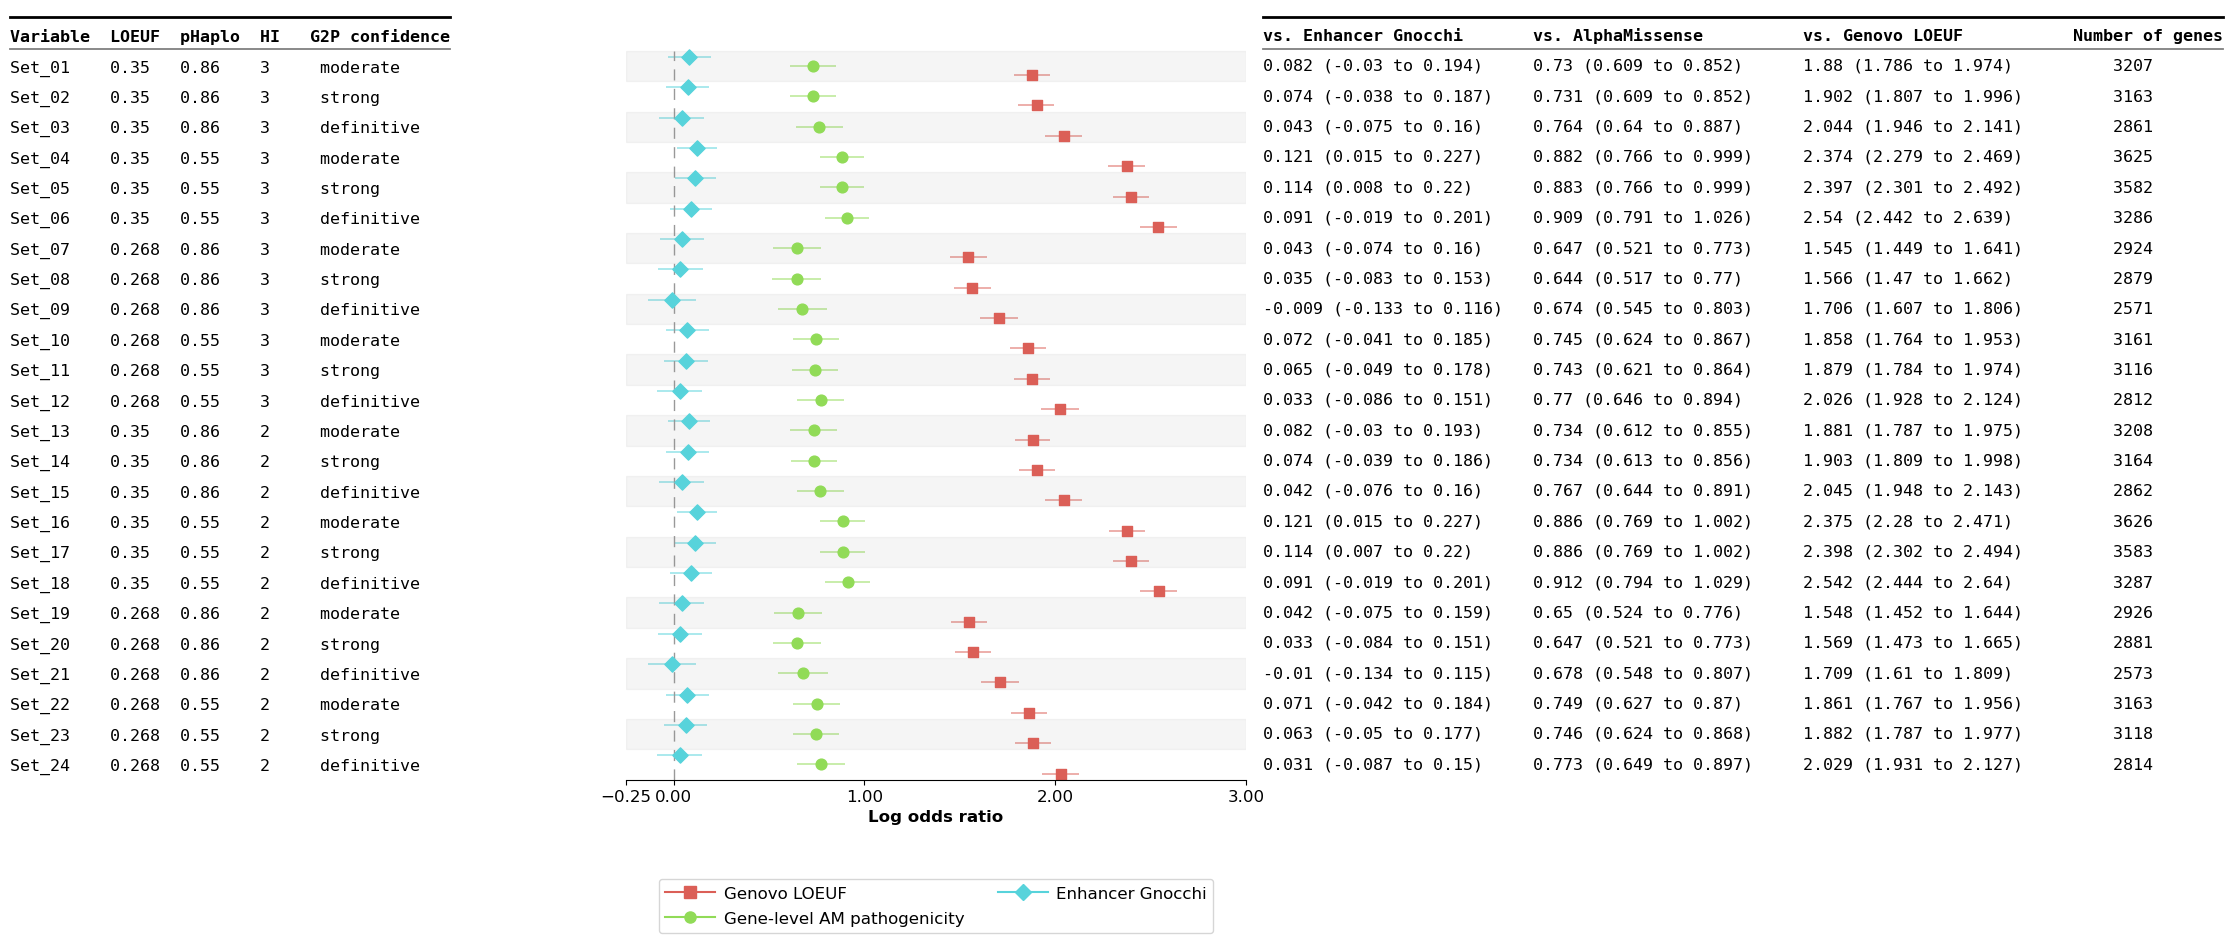

In [40]:
std_opts = dict(
    estimate = "Odds ratio",
    ll = "CI_lower", hl = "CI_upper", 
    varlabel = "Set", 
    capitalize = "capitalize",
    table = True,
    # rightannote=['Model'],
    # right_annoteheaders=['Set name'],
    xlabel = "Log odds ratio",  # x-label title
    ylabel = "log odds ratio",  # y-label title
    annote = ['oe_lof_upper', 'pHaplo', "HI_score", 'DECIPHER_definitive'] ,
    annoteheaders = ['LOEUF', 'pHaplo', "HI", 'G2P confidence'],
    rightannote = ['logorci_gnoc', 'logorci_am', 'logorci_genovo', 'Number of genes'],
    right_annoteheaders = ['vs. Enhancer Gnocchi', 'vs. AlphaMissense', 'vs. Genovo LOEUF', 'Number of genes'],
    figsize = (8, 10),
    return_df = False,
    markersize = 60,
    offset = 0.3, # override default vertical offset between models (0.0 to 1.0)
    xlinestyle = (0, (8, 6)),  # long dash for x-reference line
    xlinecolor = ".6",  # gray color for x-reference line
    xtick_size = 12,
    color_alt_rows=True,
)

fp_all = fp.mforestplot(
    dataframe = fpdf,
    xticks = [-0.25, 0, 1, 2, 3],
    **std_opts,
    logscale=False,
    model_col = "Group",
    mcolor = list(sns.hls_palette(4)),
    )

In [41]:
final_conditions = conditions_list[15]
final_elofs = create_gene_list(ajhg, alldf, higene, gnomad, *final_conditions)

final_elofs_gene = final_elofs[1]
print(len(final_elofs_gene))
df_final_elofs = pd.DataFrame(final_elofs_gene, columns=['HGNC_Approved_Symbol'])
ajhg_genes, dcpr_genes, hi_genes, gnomad_genes = create_individual_gene_list(ajhg, alldf, higene, gnomad, *final_conditions)

set_16   AJHG:DCPR:HI:pHaplo:Total - 1041 1880 370 1715 3626
3626


In [42]:
# Load from pickles
with open('pkls/ajhg_with_hgnc_id.pkl', 'rb') as f:
    ajhg = pd.read_pickle(f)

with open('pkls/alldf_with_hgnc_id.pkl', 'rb') as f:
    alldf = pd.read_pickle(f)

with open('pkls/higene_with_hgnc_id.pkl', 'rb') as f:
    higene = pd.read_pickle(f)

with open('pkls/gnomad_with_hgnc_id.pkl', 'rb') as f:
    gnomad = pd.read_pickle(f)

with open('pkls/phaplo_with_hgnc_id.pkl', 'rb') as f:
    phaplo = pd.read_pickle(f)

with open('pkls/am_with_hgnc_id.pkl', 'rb') as f:
    am = pd.read_pickle(f)

with open('pkls/genovo_with_hgnc_id.pkl', 'rb') as f:
    genovo = pd.read_pickle(f)

with open('pkls/gnocchi_with_hgnc_id.pkl', 'rb') as f:
    gnocchi = pd.read_pickle(f)

In [43]:
# Merge data with df_final_elofs and gnocchi, genovo, am (key is Apprioved_Symbol)
final_genes = pd.merge(
	df_final_elofs, gnocchi, how='left', left_on='HGNC_Approved_Symbol', right_on='Approved_Symbol')

final_genes = pd.merge(
	final_genes, genovo, how='left', left_on='HGNC_Approved_Symbol', right_on='Approved_Symbol')

final_genes = pd.merge(
	final_genes, am, how='left', left_on='HGNC_Approved_Symbol', right_on='Approved_Symbol')

final_genes = final_genes[
	['HGNC_Approved_Symbol', 'enhancer_Gnocchi', 'genovo_LOEUF_corrected', 'mean_am_pathogenicity']
	]

# Merge with gnomad, phaplo, higene, ajhg
# Add column for ajhg genes DataFrame ('Curated_by_AJHG_papaer_from_ClinGen' = True)
def add_source_info(x, set_name):
	if x in set_name:
		return True
	else:
		return False
	
gnomad = gnomad[['Approved_Symbol', 'pLI', 'oe_lof_upper']]
final_genes = pd.merge(
	final_genes, gnomad, how='left', left_on='HGNC_Approved_Symbol', right_on='Approved_Symbol')

final_genes = pd.merge(
	final_genes, phaplo, how='left', left_on='HGNC_Approved_Symbol', right_on='Approved_Symbol')

final_genes = pd.merge(
	final_genes, higene, how='left', left_on='HGNC_Approved_Symbol', right_on='Approved_Symbol')

final_genes['Curated_by_ClinGenSVI_group'] = final_genes['HGNC_Approved_Symbol'].apply(add_source_info, args=(ajhg_genes,))
final_genes['Curated_from_G2P'] = final_genes['HGNC_Approved_Symbol'].apply(add_source_info, args=(dcpr_genes,))

# Fill NaN with "NA"
final_genes.fillna('NA', inplace=True)

# Cast dtype
final_genes['HIscore'] = final_genes['HIscore'].astype(pd.Int64Dtype(), errors='ignore')
final_genes['pLI'] = final_genes['pLI'].astype(pd.Float64Dtype(), errors='ignore')

# Annotate HGNC IDs
final_genes['HGNC_ID'] = final_genes['HGNC_Approved_Symbol'].apply(fetch_hgnc_id_by_approved_symbol)

In [44]:
final_genes = final_genes[
	['HGNC_Approved_Symbol', 'HGNC_ID', 'pLI', 'oe_lof_upper', 'pHaplo', 'HIscore', 
  'enhancer_Gnocchi', 'mean_am_pathogenicity', 'genovo_LOEUF_corrected',
  'Curated_by_ClinGenSVI_group', 'Curated_from_G2P']]

In [45]:
final_genes.rename(
	{'oe_lof_upper': 'LOEUF_gnomAD_v2.1.1', 
  'enhancer_Gnocchi': 'Enhancer_Gnocchi', 
  'genovo_LOEUF_corrected': 'Genovo_LOEUF_corrected', 
  'mean_am_pathogenicity': 'Mean_AlphaMissense_pathogenicity'}, axis=1, inplace=True)

In [47]:
final_genes.head()

,HGNC_Approved_Symbol,HGNC_ID,pLI,LOEUF_gnomAD_v2.1.1,pHaplo,HIscore,Enhancer_Gnocchi,Mean_AlphaMissense_pathogenicity,Genovo_LOEUF_corrected,Curated_by_ClinGenSVI_group,Curated_from_G2P
0,RARB,HGNC:9865,0.99983,0.12,0.996622,NA,-2.556487,NA,0.125948,False,True
1,LGI4,HGNC:18712,0.00715,0.684,0.243715,NA,3.322926,0.426376,0.693512,True,True
2,TP53RK,HGNC:16197,0.000775,1.651,0.210387,NA,3.384303,0.471078,2.174757,False,True
3,BHLHE41,HGNC:16617,0.99212,0.206,0.945621,NA,3.483576,0.409067,0.517385,False,False
4,MSH6,HGNC:7329,0.000037,0.498,0.606599,3.0,1.827315,0.423953,0.853019,True,True


In [48]:
# Output TSV file
final_genes.to_csv(f'Final_eLoF_genes_list/Supplementary_Data_Estimated_LoF_genes.tsv', sep='\t', index=False)

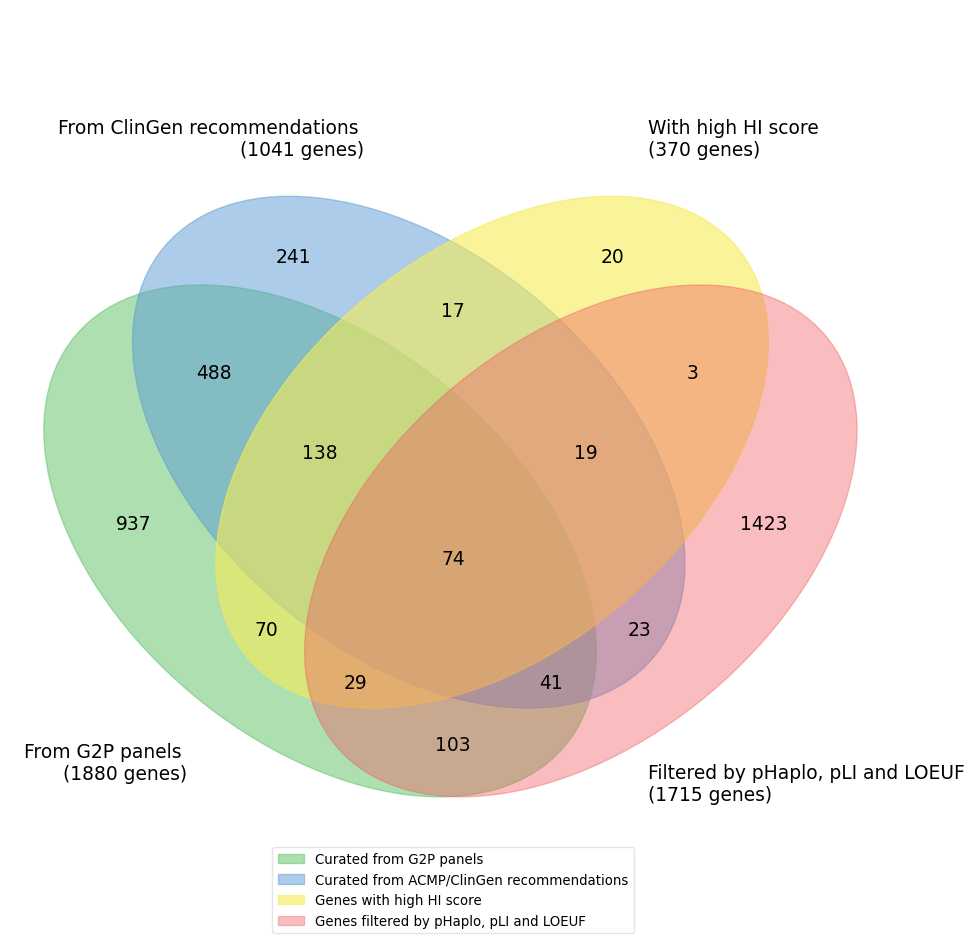

In [29]:
labels = get_labels([dcpr_genes, ajhg_genes, hi_genes, gnomad_genes], fill=['number'])
fig, ax = venn4(
       labels, 
       names=[f'From G2P panels \n({len(dcpr_genes)} genes)',
              f'From ClinGen recommendations \n({len(ajhg_genes)} genes)',
              f'With high HI score \n({len(hi_genes)} genes)', 
              f'Filtered by pHaplo, pLI and LOEUF\n({len(gnomad_genes)} genes)'
              ],
       leg_names=[
              'Curated from G2P panels',
              "Curated from ACMP/ClinGen recommendations",
              'Genes with high HI score', 
              'Genes filtered by pHaplo, pLI and LOEUF'
              ]
       )

#### venn.py functions

In [24]:
# coding: utf-8
from itertools import chain
try:
    # since python 3.10
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import math

default_colors = [
    # r, g, b, a
    [92, 192, 98, 0.5],
    [90, 155, 212, 0.5],
    [246, 236, 86, 0.6],
    [241, 90, 96, 0.4],
    [255, 117, 0, 0.3],
    [82, 82, 190, 0.2],
]
default_colors = [
    [i[0] / 255.0, i[1] / 255.0, i[2] / 255.0, i[3]]
    for i in default_colors
]

def draw_ellipse(fig, ax, x, y, w, h, a, fillcolor):
    e = patches.Ellipse(
        xy=(x, y),
        width=w,
        height=h,
        angle=a,
        color=fillcolor)
    ax.add_patch(e)

def draw_triangle(fig, ax, x1, y1, x2, y2, x3, y3, fillcolor):
    xy = [
        (x1, y1),
        (x2, y2),
        (x3, y3),
    ]
    polygon = patches.Polygon(
        xy=xy,
        closed=True,
        color=fillcolor)
    ax.add_patch(polygon)

def draw_text(fig, ax, x, y, text, color=[0, 0, 0, 1], fontsize=14, ha="center", va="center"):
    ax.text(
        x, y, text,
        horizontalalignment=ha,
        verticalalignment=va,
        fontsize=fontsize,
        color="black")

def draw_annotate(fig, ax, x, y, textx, texty, text, color=[0, 0, 0, 1], arrowcolor=[0, 0, 0, 0.3]):
    plt.annotate(
        text,
        xy=(x, y),
        xytext=(textx, texty),
        arrowprops=dict(color=arrowcolor, shrink=0, width=0.5, headwidth=8),
        fontsize=14,
        color=color,
        xycoords="data",
        textcoords="data",
        horizontalalignment='center',
        verticalalignment='center'
    )

def get_labels(data, fill=["number"]):
    """
    get a dict of labels for groups in data

    @type data: list[Iterable]
    @rtype: dict[str, str]

    input
      data: data to get label for
      fill: ["number"|"logic"|"percent"]

    return
      labels: a dict of labels for different sets

    example:
    In [12]: get_labels([range(10), range(5,15), range(3,8)], fill=["number"])
    Out[12]:
    {'001': '0',
     '010': '5',
     '011': '0',
     '100': '3',
     '101': '2',
     '110': '2',
     '111': '3'}
    """

    N = len(data)

    sets_data = [set(data[i]) for i in range(N)]  # sets for separate groups
    s_all = set(chain(*data))                     # union of all sets

    # bin(3) --> '0b11', so bin(3).split('0b')[-1] will remove "0b"
    set_collections = {}
    for n in range(1, 2**N):
        key = bin(n).split('0b')[-1].zfill(N)
        value = s_all
        sets_for_intersection = [sets_data[i] for i in range(N) if  key[i] == '1']
        sets_for_difference = [sets_data[i] for i in range(N) if  key[i] == '0']
        for s in sets_for_intersection:
            value = value & s
        for s in sets_for_difference:
            value = value - s
        set_collections[key] = value

    labels = {k: "" for k in set_collections}
    if "logic" in fill:
        for k in set_collections:
            labels[k] = k + ": "
    if "number" in fill:
        for k in set_collections:
            labels[k] += str(len(set_collections[k]))
    if "percent" in fill:
        data_size = len(s_all)
        for k in set_collections:
            labels[k] += "(%.1f%%)" % (100.0 * len(set_collections[k]) / data_size)

    return labels

def venn2(labels, names=['A', 'B'], **options):
    """
    plots a 2-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('01', '10', '11'),
              hence a valid set could look like: {'01': 'text 1', '10': 'text 2', '11': 'text 3'}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(2)])
    figsize = options.get('figsize', (9, 7))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=0.7)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.375, 0.3, 0.5, 0.5, 0.0, colors[0])
    draw_ellipse(fig, ax, 0.625, 0.3, 0.5, 0.5, 0.0, colors[1])
    draw_text(fig, ax, 0.74, 0.30, labels.get('01', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.26, 0.30, labels.get('10', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.30, labels.get('11', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.20, 0.56, names[0], colors[0], fontsize=fontsize, ha="right", va="bottom")
    draw_text(fig, ax, 0.80, 0.56, names[1], colors[1], fontsize=fontsize, ha="left", va="bottom")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn3(labels, names=['A', 'B', 'C'], **options):
    """
    plots a 3-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('001', '010', '100', ...),
              hence a valid set could look like: {'001': 'text 1', '010': 'text 2', '100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(3)])
    figsize = options.get('figsize', (9, 9))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.333, 0.633, 0.5, 0.5, 0.0, colors[0])
    draw_ellipse(fig, ax, 0.666, 0.633, 0.5, 0.5, 0.0, colors[1])
    draw_ellipse(fig, ax, 0.500, 0.310, 0.5, 0.5, 0.0, colors[2])
    draw_text(fig, ax, 0.50, 0.27, labels.get('001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.73, 0.65, labels.get('010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.61, 0.46, labels.get('011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.27, 0.65, labels.get('100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.46, labels.get('101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.65, labels.get('110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.51, labels.get('111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.15, 0.87, names[0], colors[0], fontsize=fontsize, ha="right", va="bottom")
    draw_text(fig, ax, 0.85, 0.87, names[1], colors[1], fontsize=fontsize, ha="left", va="bottom")
    draw_text(fig, ax, 0.50, 0.02, names[2], colors[2], fontsize=fontsize, va="top")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn4(labels, names=['A', 'B', 'C', 'D'], leg_names=['A2', 'B2', 'C2', 'D2'], **options):
    """
    plots a 4-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('0001', '0010', '0100', ...),
              hence a valid set could look like: {'0001': 'text 1', '0010': 'text 2', '0100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(4)])
    figsize = options.get('figsize', (12, 12))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.350, 0.400, 0.72, 0.45, 140.0, colors[0])
    draw_ellipse(fig, ax, 0.450, 0.500, 0.72, 0.45, 140.0, colors[1])
    draw_ellipse(fig, ax, 0.544, 0.500, 0.72, 0.45, 40.0, colors[2])
    draw_ellipse(fig, ax, 0.644, 0.400, 0.72, 0.45, 40.0, colors[3])
    draw_text(fig, ax, 0.85, 0.42, labels.get('0001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.68, 0.72, labels.get('0010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.77, 0.59, labels.get('0011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.32, 0.72, labels.get('0100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.71, 0.30, labels.get('0101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.66, labels.get('0110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.65, 0.50, labels.get('0111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.14, 0.42, labels.get('1000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.17, labels.get('1001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.29, 0.30, labels.get('1010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.24, labels.get('1011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.23, 0.59, labels.get('1100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.61, 0.24, labels.get('1101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.35, 0.50, labels.get('1110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.38, labels.get('1111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.20, 0.15, names[0], colors[0], fontsize=fontsize, ha="right")
    draw_text(fig, ax, 0.40, 0.83, names[1], colors[1], fontsize=fontsize, ha="right", va="bottom")
    draw_text(fig, ax, 0.72, 0.83, names[2], colors[2], fontsize=fontsize, ha="left", va="bottom")
    draw_text(fig, ax, 0.72, 0.15, names[3], colors[3], fontsize=fontsize, ha="left", va="top")
    leg = ax.legend(leg_names, loc='lower center', bbox_to_anchor=(0.5, -0.05), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn5(labels, names=['A', 'B', 'C', 'D', 'E'], **options):
    """
    plots a 5-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('00001', '00010', '00100', ...),
              hence a valid set could look like: {'00001': 'text 1', '00010': 'text 2', '00100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(5)])
    figsize = options.get('figsize', (13, 13))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.428, 0.449, 0.87, 0.50, 155.0, colors[0])
    draw_ellipse(fig, ax, 0.469, 0.543, 0.87, 0.50, 82.0, colors[1])
    draw_ellipse(fig, ax, 0.558, 0.523, 0.87, 0.50, 10.0, colors[2])
    draw_ellipse(fig, ax, 0.578, 0.432, 0.87, 0.50, 118.0, colors[3])
    draw_ellipse(fig, ax, 0.489, 0.383, 0.87, 0.50, 46.0, colors[4])
    draw_text(fig, ax, 0.27, 0.11, labels.get('00001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.72, 0.11, labels.get('00010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.55, 0.13, labels.get('00011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.91, 0.58, labels.get('00100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.78, 0.64, labels.get('00101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.84, 0.41, labels.get('00110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.76, 0.55, labels.get('00111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.90, labels.get('01000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.15, labels.get('01001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.42, 0.78, labels.get('01010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.15, labels.get('01011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.67, 0.76, labels.get('01100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.70, 0.71, labels.get('01101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.74, labels.get('01110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.64, 0.67, labels.get('01111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.10, 0.61, labels.get('10000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.20, 0.31, labels.get('10001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.76, 0.25, labels.get('10010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.65, 0.23, labels.get('10011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.18, 0.50, labels.get('10100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.21, 0.37, labels.get('10101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.81, 0.37, labels.get('10110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.74, 0.40, labels.get('10111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.27, 0.70, labels.get('11000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.34, 0.25, labels.get('11001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.33, 0.72, labels.get('11010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.22, labels.get('11011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.25, 0.58, labels.get('11100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.28, 0.39, labels.get('11101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.36, 0.66, labels.get('11110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.47, labels.get('11111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.02, 0.72, names[0], colors[0], fontsize=fontsize, ha="right")
    draw_text(fig, ax, 0.72, 0.94, names[1], colors[1], fontsize=fontsize, va="bottom")
    draw_text(fig, ax, 0.97, 0.74, names[2], colors[2], fontsize=fontsize, ha="left")
    draw_text(fig, ax, 0.88, 0.05, names[3], colors[3], fontsize=fontsize, ha="left")
    draw_text(fig, ax, 0.12, 0.05, names[4], colors[4], fontsize=fontsize, ha="right")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn6(labels, names=['A', 'B', 'C', 'D', 'E'], **options):
    """
    plots a 6-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('000001', '000010', '000100', ...),
              hence a valid set could look like: {'000001': 'text 1', '000010': 'text 2', '000100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(6)])
    figsize = options.get('figsize', (20, 20))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.230, top=0.845)
    ax.set_xlim(left=0.173, right=0.788)

    # body
    # See https://web.archive.org/web/20040819232503/http://www.hpl.hp.com/techreports/2000/HPL-2000-73.pdf
    draw_triangle(fig, ax, 0.637, 0.921, 0.649, 0.274, 0.188, 0.667, colors[0])
    draw_triangle(fig, ax, 0.981, 0.769, 0.335, 0.191, 0.393, 0.671, colors[1])
    draw_triangle(fig, ax, 0.941, 0.397, 0.292, 0.475, 0.456, 0.747, colors[2])
    draw_triangle(fig, ax, 0.662, 0.119, 0.316, 0.548, 0.662, 0.700, colors[3])
    draw_triangle(fig, ax, 0.309, 0.081, 0.374, 0.718, 0.681, 0.488, colors[4])
    draw_triangle(fig, ax, 0.016, 0.626, 0.726, 0.687, 0.522, 0.327, colors[5])
    draw_text(fig, ax, 0.212, 0.562, labels.get('000001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.430, 0.249, labels.get('000010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.356, 0.444, labels.get('000011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.609, 0.255, labels.get('000100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.323, 0.546, labels.get('000101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.513, 0.316, labels.get('000110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.523, 0.348, labels.get('000111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.747, 0.458, labels.get('001000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.325, 0.492, labels.get('001001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.670, 0.481, labels.get('001010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.359, 0.478, labels.get('001011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.444, labels.get('001100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.344, 0.526, labels.get('001101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.466, labels.get('001110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.363, 0.503, labels.get('001111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.750, 0.616, labels.get('010000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.682, 0.654, labels.get('010001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.402, 0.310, labels.get('010010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.392, 0.421, labels.get('010011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.691, labels.get('010100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.651, 0.644, labels.get('010101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.490, 0.340, labels.get('010110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.468, 0.399, labels.get('010111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.692, 0.545, labels.get('011000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.666, 0.592, labels.get('011001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.665, 0.496, labels.get('011010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.374, 0.470, labels.get('011011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.537, labels.get('011100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.652, 0.579, labels.get('011101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.488, labels.get('011110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.389, 0.486, labels.get('011111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.553, 0.806, labels.get('100000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.313, 0.604, labels.get('100001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.388, 0.694, labels.get('100010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.375, 0.633, labels.get('100011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.605, 0.359, labels.get('100100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.334, 0.555, labels.get('100101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.582, 0.397, labels.get('100110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.542, 0.372, labels.get('100111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.468, 0.708, labels.get('101000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.355, 0.572, labels.get('101001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.420, 0.679, labels.get('101010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.375, 0.597, labels.get('101011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.641, 0.436, labels.get('101100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.348, 0.538, labels.get('101101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.635, 0.453, labels.get('101110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.370, 0.548, labels.get('101111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.594, 0.689, labels.get('110000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.579, 0.670, labels.get('110001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.398, 0.670, labels.get('110010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.395, 0.653, labels.get('110011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.633, 0.682, labels.get('110100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.616, 0.656, labels.get('110101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.587, 0.427, labels.get('110110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.526, 0.415, labels.get('110111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.495, 0.677, labels.get('111000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.505, 0.648, labels.get('111001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.428, 0.663, labels.get('111010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.430, 0.631, labels.get('111011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.639, 0.524, labels.get('111100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.591, 0.604, labels.get('111101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.622, 0.477, labels.get('111110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.501, 0.523, labels.get('111111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.674, 0.824, names[0], colors[0], fontsize=fontsize)
    draw_text(fig, ax, 0.747, 0.751, names[1], colors[1], fontsize=fontsize)
    draw_text(fig, ax, 0.739, 0.396, names[2], colors[2], fontsize=fontsize)
    draw_text(fig, ax, 0.700, 0.247, names[3], colors[3], fontsize=fontsize)
    draw_text(fig, ax, 0.291, 0.255, names[4], colors[4], fontsize=fontsize)
    draw_text(fig, ax, 0.203, 0.484, names[5], colors[5], fontsize=fontsize)
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax